# <b>Tarzan: What's Jane's favorite flower? 🤔</b>

![Tarzan.png](https://github.com/mdai/tarzan-ai/blob/main/images/Tarzan.png?raw=true)

<b>Background</b> 

In the Korean TV series - Start-Up, a young entrepreneur, Do-San uses an analogy of Tarzan and Jane to explain how machine learning works. Watch the clip [here](https://www.youtube.com/watch?v=XDiCGa1xtrQ/)

MD.ai wants to help Tarzan AI learn Jane's favortite flower, roses or tulips? In this example, we assume Jane only likes tulips. To train Tarzan AI, we annotated some example images of these two flowers as "Jane Likes ❤️" or "Jane Dislikes 😔" on MD.ai Annotator. This project contain 3 datasets, "train", "validation", and "test", and we'll see if Tarzan AI will learn to predict Jane's favorite flower using the test dataset. 

Check out the [project](https://public.md.ai/annotator/project/nxN1d4R6). You can `clone` the project on MD.ai, try to annotate yourself, and see if you can classify flowers better than Tarzan 🤓


![annotator.png](https://github.com/mdai/tarzan-ai/blob/main/images/annotator.png?raw=true)

**MD.ai showing a photo of tulips which `Jane Likes ❤️` (pink label) and Tarzan AI's correct prediction of `Jane Likes ❤️` (striped pink label)**

## Import Python packages

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 4.3MB/s 


In [ ]:
from matplotlib import colors, cm, pyplot as plt
from scipy.ndimage.interpolation import zoom

import pydicom
import numpy as np 
import pandas as pd
import os 
import json

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from tqdm import tqdm
torch.manual_seed(88); np.random.seed(88)

## Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [ ]:
!pip install --upgrade --quiet mdai

     |████████████████████████████████| 51kB 4.8MB/s 


In [ ]:
import mdai
mdai.__version__

'0.6.0'

## Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [ ]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="")

Successfully authenticated to public.md.ai.


## Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `nxN1d4R6` for `https://public.md.ai/annotator/project/nxN1d4R6/`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [ ]:
p = mdai_client.project('nxN1d4R6', path='/data/FunProjects', force_download=True)

Using path '/data/FunProjects' for data.
Preparing annotations export for project nxN1d4R6...                                                
Preparing images export for project nxN1d4R6...                                                     


64.0kB [00:00, 25.9MB/s]                   
  0%|          | 0.00/20.0M [00:00<?, ?B/s]

Success: annotations data for project nxN1d4R6 ready.


20.0MB [00:00, 65.5MB/s]                            

Extracting archive: mdai_public_project_nxN1d4R6_images_2021-02-01-211104.zip
Success: images data for project nxN1d4R6 ready.


### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [ ]:
p.show_label_groups()

Label Group, Id: G_j5YmN5, Name: Jane's Favorite Flower
	Labels:
	Id: L_8GwPG8, Name: Jane Likes ❤️
	Id: L_B7vLb8, Name: Jane Dislikes 😔



In [ ]:
# this maps label ids to class ids as a dict obj
labels_dict = {'L_B7vLb8':0, # Jane Dislikes 
               'L_8GwPG8':1, # Jane Likes
              }
# this maps label index to label names as a dict obj
label_index_to_name = {0: "Jane Dislikes 😔",
                       1: "Jane Likes ❤️"}
                       
print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_B7vLb8': 0, 'L_8GwPG8': 1}


## Create the *Training* and *Validation* datasets

In [ ]:
p.show_datasets() 

Datasets:
Id: D_vEp0gE, Name: Train
Id: D_nQa5wQ, Name: Validation
Id: D_DNP2ro, Name: Test



In [ ]:
# create training dataset 
train_dataset = p.get_dataset_by_name('Train')
train_dataset.prepare() 
train_image_ids = train_dataset.get_image_ids()
print(len(train_image_ids))

# create the validation dataset 
val_dataset = p.get_dataset_by_name('Validation')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()
print(len(val_image_ids))

30
17


### Display a few images

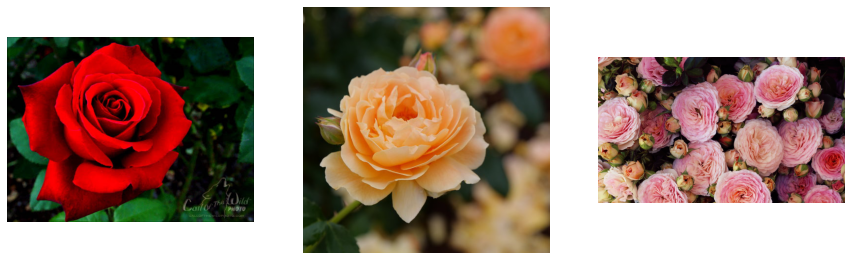

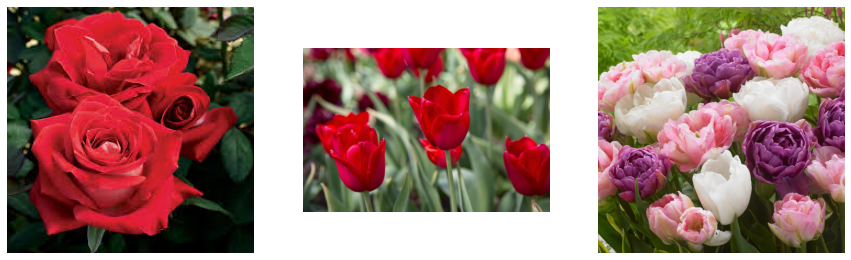

In [ ]:
# visualize a few train images 
fig = plt.figure(figsize=(15,20))
for i, img in enumerate(train_image_ids[:3]):
    fig.add_subplot(1,3,i+1)
    plt.imshow(pydicom.pixel_data_handlers.util.convert_color_space(pydicom.dcmread(img).pixel_array, "YBR_FULL_422", "RGB"))
    plt.axis("off")

# visualize a few val images 
fig = plt.figure(figsize=(15,20))
for i, img in enumerate(val_image_ids[:3]):
    fig.add_subplot(1,3,i+1)
    plt.imshow(pydicom.pixel_data_handlers.util.convert_color_space(pydicom.dcmread(img).pixel_array, "YBR_FULL_422", "RGB"))
    plt.axis("off")

## Set up data generation and augmentation

In [ ]:
class FlowerDataset(Dataset):
    def load_dicom(self, dicom_file): 
        '''
        Given a DICOM file, window specifications, and image size, 
        return the image as a Numpy array scaled to [0,255] of the specified size. 
        '''
        ds = pydicom.dcmread(dicom_file[0])
        array = ds.pixel_array.copy() 
        label = dicom_file[1]
        
        scale_slope = 1
        scale_intercept = 0
        if "RescaleIntercept" in ds:
            scale_intercept =  int(ds.RescaleIntercept)
        if "RescaleIntercept" in ds:
            scale_slope = int(ds.RescaleSlope) 
        array =  array + scale_intercept
        array = array * scale_slope
        return array, label
    
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, x):
        img, label = self.load_dicom(self.dataset[x])
        img = pydicom.pixel_data_handlers.util.convert_color_space(img, "YBR_FULL_422", "RGB")
        if self.transform is not None:
            img = self.transform(img)
        return (img,label)

In [ ]:
train_data = train_dataset.imgs_anns_dict
train_data = [(i,labels_dict[train_data[i][0]["labelId"]]) for i in train_data]

val_data = val_dataset.imgs_anns_dict
val_data = [(i,labels_dict[val_data[i][0]["labelId"]]) for i in val_data]

In [ ]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((120,120)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((120,120)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_df = FlowerDataset(train_data, train_transform)
val_df = FlowerDataset(val_data, val_transform)

### View sample training data

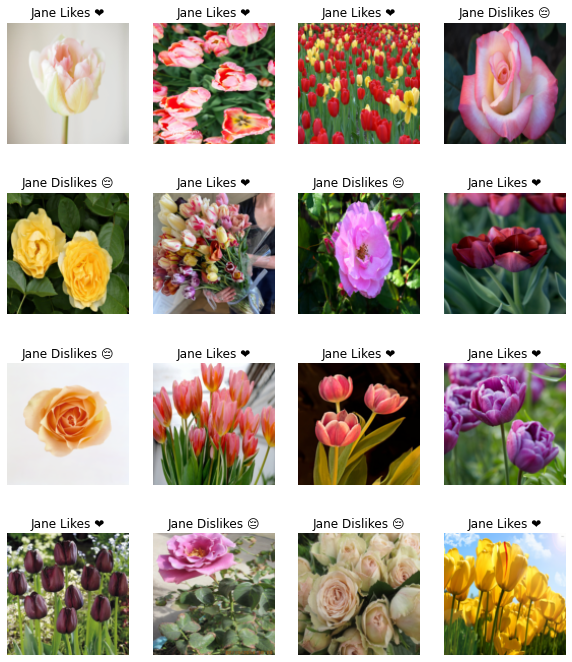

In [ ]:
rand_inds = np.random.choice(np.arange(len(train_df)), 16, replace=False)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

fig = plt.figure(figsize = (10,12))
for i, img in enumerate([train_df[i] for i in rand_inds]):
    fig.add_subplot(4,4,i+1)
    plt.imshow(np.transpose(
            inv_normalize(img[0]).numpy(),(1,2,0)))
    plt.title(label_index_to_name[img[1]])
    plt.axis('off')

In [ ]:
# Create dataloaders
train_loader = DataLoader(train_df, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_df, batch_size = 16, shuffle = False)

## Model

In [ ]:
N_CLASSES = len(labels_dict)
EPOCHS = 5
INITIAL_LR = 1e-4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(in_features = 1280, out_features=N_CLASSES, bias = True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)

## Training

In [ ]:
def evaluate(val_loader, model):
    model.eval()
    correct = 0.0
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for data in tqdm(val_loader, desc = "Validation"):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            predicted = torch.softmax(outputs, dim=1)
            predicted = torch.max(outputs,axis=1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss/len(val_loader.dataset), correct / total

In [ ]:
best_val_acc = 0.0
train_losses, train_accs, val_losses, val_accs = [],[],[],[]
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0.0, 0.0
    for i, data in enumerate(tqdm(train_loader, desc = f"Epoch {epoch+1}")):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)#.reshape(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.softmax(outputs, dim=1)
        predicted = torch.max(outputs,axis=1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
    val_loss, val_acc = evaluate(val_loader, model)
    train_losses.append(running_loss/len(train_loader.dataset))
    val_losses.append(val_loss.item())
    train_accs.append(correct/total)
    val_accs.append(val_acc)

    print('\nTrain loss: %.3f | Train acc: %.3f | Val loss: %.3f | Val acc: %.3f' %(
        running_loss / len(train_loader.dataset), correct/total, val_loss, val_acc))
    
    # if val_acc >= best_val_acc:
    #     best_val_acc = val_acc
    #     print("Saving best model")
    #     torch.save(model.state_dict(), "best_flower_model.pth")
    print()
print('Finished Training')

Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.045 | Train acc: 0.533 | Val loss: 0.057 | Val acc: 0.647



Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.025 | Train acc: 0.867 | Val loss: 0.047 | Val acc: 0.824



Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.015 | Train acc: 0.967 | Val loss: 0.037 | Val acc: 0.882



Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.011 | Train acc: 1.000 | Val loss: 0.030 | Val acc: 0.941



Validation: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it]


Train loss: 0.006 | Train acc: 1.000 | Val loss: 0.025 | Val acc: 0.941

Finished Training


Text(0.5, 1.0, 'Accuracy')

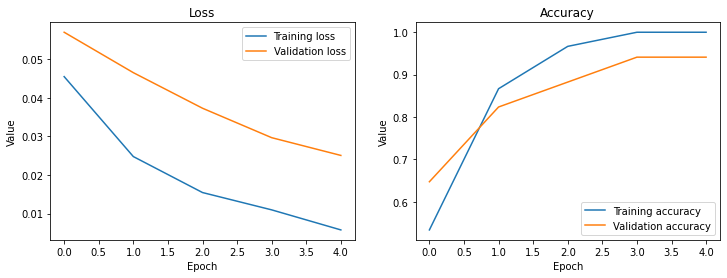

In [ ]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(1,2,1)
plt.plot(train_losses, label = "Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Loss")

fig.add_subplot(1,2,2)
plt.plot(train_accs, label = "Training accuracy")
plt.plot(val_accs, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Accuracy")

## View predictions on test set

In [ ]:
test_dataset = p.get_dataset_by_name('Test')
test_dataset.prepare() 
test_image_ids = test_dataset.get_image_ids()
print(len(test_image_ids))

12


In [ ]:
test_data = test_dataset.imgs_anns_dict
test_data = [(i,labels_dict[test_data[i][0]["labelId"]]) for i in test_data]

test_df = FlowerDataset(test_data, val_transform)
test_loader = DataLoader(test_df, batch_size = 1, shuffle = False)

In [ ]:
def predict_test(model, test_loader):
    '''
    Small modifications to data generator to allow for prediction on test data.
    '''
    test_arrays = [] 
    test_labels = [] 
    test_probas = []
    model.eval()
    with torch.no_grad():
         for data in tqdm(test_loader, desc = "Test"):
            inputs, label = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            predicted = torch.softmax(outputs, dim=1)
            predicted = torch.max(predicted,axis=1)[1]
            test_arrays.append(inputs) 
            test_labels.append(label)
            test_probas.append(predicted)
    return test_arrays, test_labels, test_probas

Test: 100%|██████████| 12/12 [00:01<00:00,  6.89it/s]


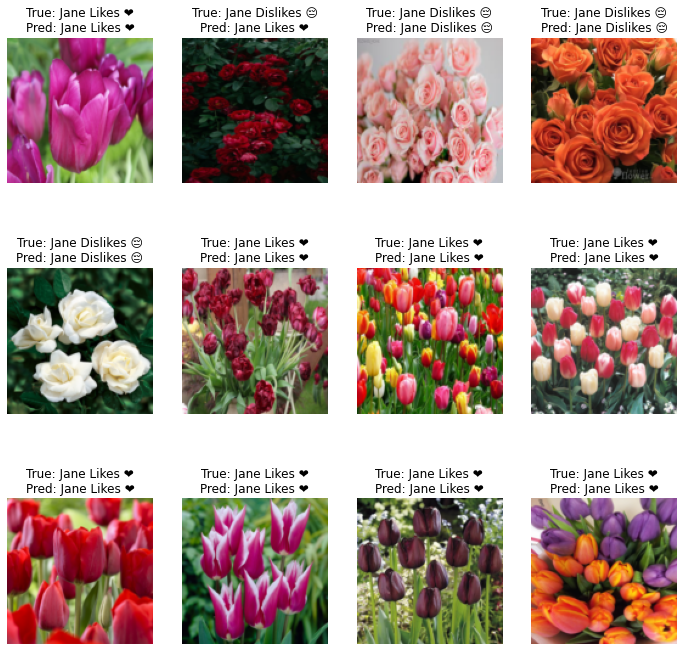

In [ ]:
ims, labs, probs = predict_test(model, test_loader)
fig = plt.figure(figsize = (12,12))
for i, img in enumerate(ims):
    fig.add_subplot(3,4,i+1)
    plt.imshow(np.transpose(inv_normalize(img[0].cpu()).numpy(),(1,2,0)))
    plt.title(f"True: {label_index_to_name[labs[i].item()]}\nPred: {label_index_to_name[probs[i].item()]}")
    plt.axis("off")

## Conclusion

Tarzan did an excellent job learning that Jane likes tulips, not roses. He still makes a few mistakes, but we are confident Tarzan will get better after spending more time with Jane. The next article will describe model training and validation. Stay tuned.

If you have any inquiries, please contact tarzan@md.ai

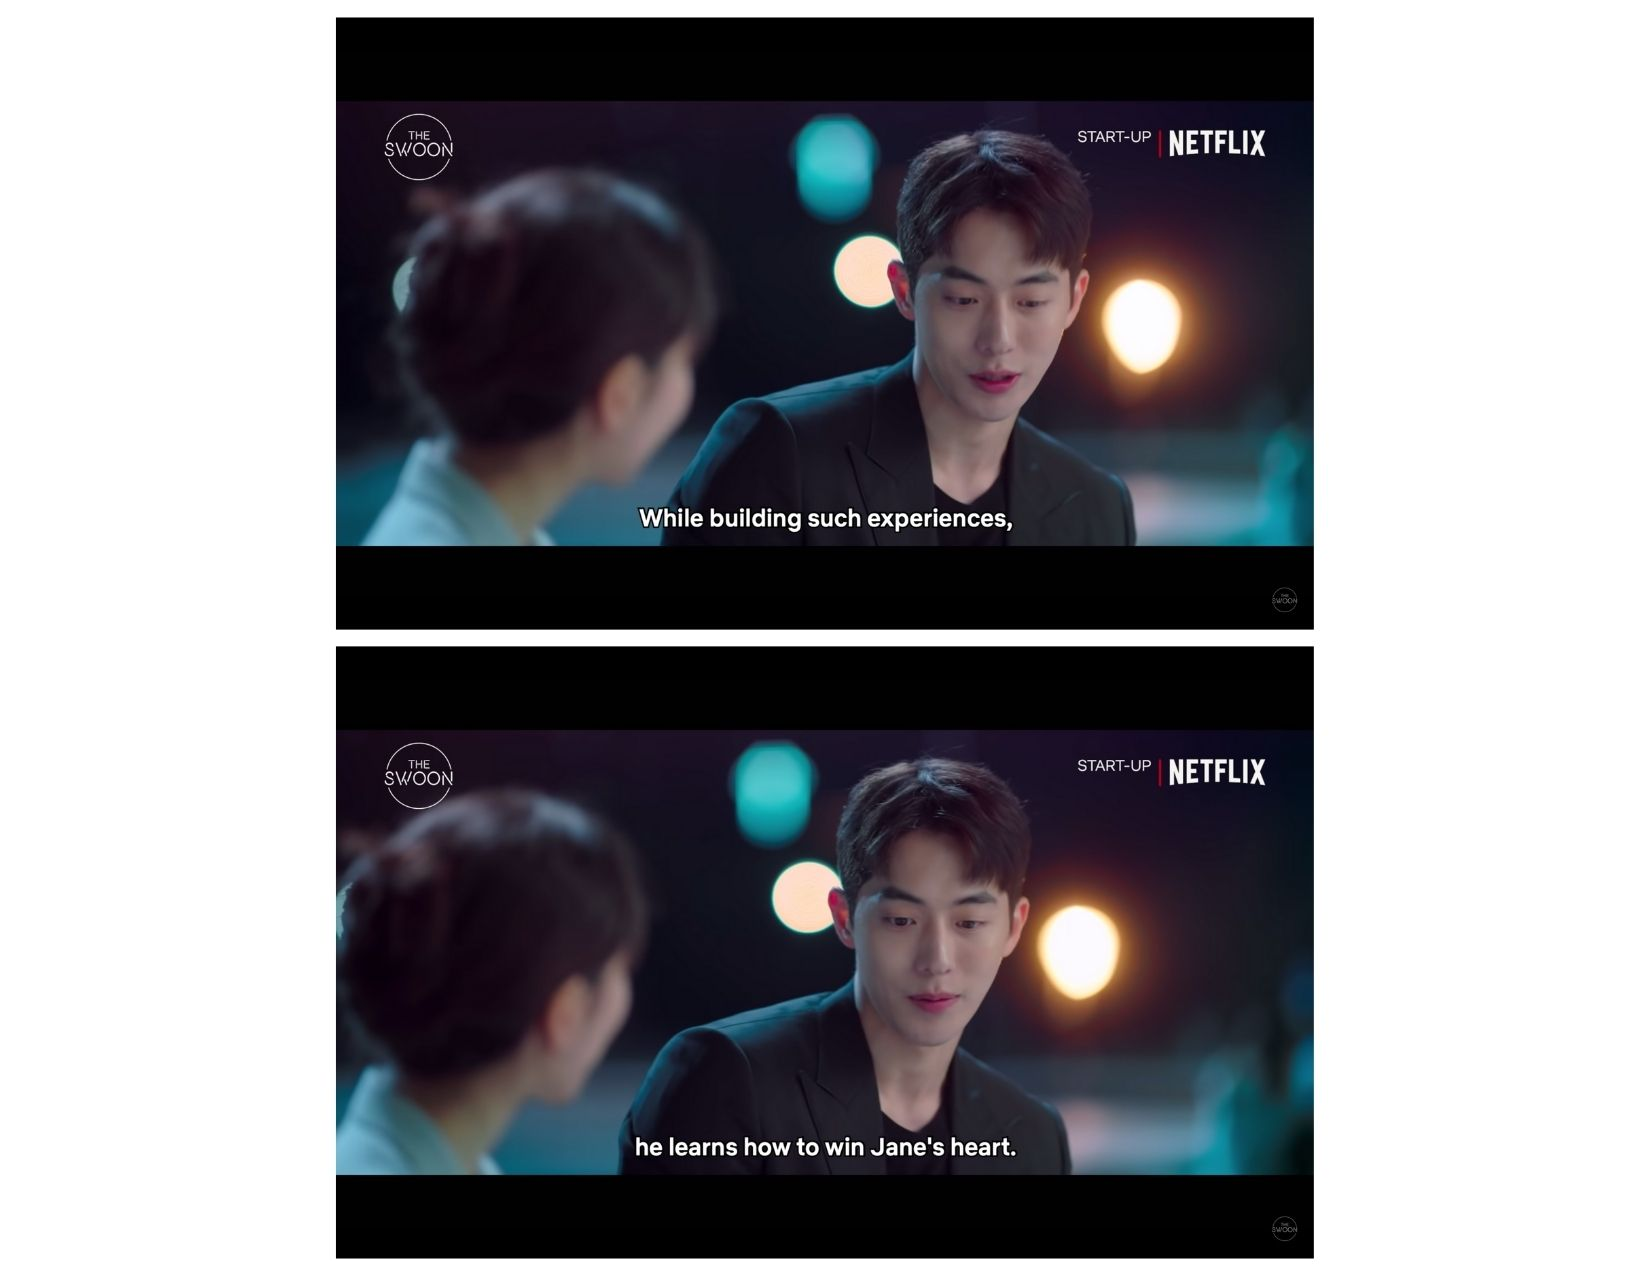
Source: [The Swoon](https://www.youtube.com/watch?v=XDiCGa1xtrQ%2F)